In [ ]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from sklearn.metrics import mean_squared_error

In [ ]:
# Loading the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HDFCBANK.csv")

In [ ]:
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,NaN,NaN,NaN
1,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,NaN,NaN,NaN
2,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,NaN,NaN,NaN
3,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,NaN,NaN,NaN
4,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,2020-11-23,HDFCBANK,EQ,1403.65,1415.00,1423.65,1375.35,1397.30,1394.60,1398.55,12623318,1.765438e+15,297107.0,5172382.0,0.4097
5200,2020-11-24,HDFCBANK,EQ,1394.60,1408.00,1445.00,1402.05,1444.00,1438.20,1430.00,20077200,2.871049e+15,341801.0,10998578.0,0.5478
5201,2020-11-25,HDFCBANK,EQ,1438.20,1451.30,1464.40,1397.00,1406.50,1402.80,1431.81,12076301,1.729097e+15,310836.0,3864872.0,0.3200
5202,2020-11-26,HDFCBANK,EQ,1402.80,1415.00,1432.00,1387.00,1431.90,1426.65,1410.64,13971563,1.970889e+15,269679.0,3873907.0,0.2773


In [ ]:
# Looking for required columns
df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [ ]:
# Looking for missing values
df.Close.isnull().sum()

0

In [ ]:
# Creating data series of the required data
stock = df['Close']
stock

0        170.00
1        173.80
2        166.95
3        168.30
4        168.35
         ...   
5199    1394.60
5200    1438.20
5201    1402.80
5202    1426.65
5203    1440.85
Name: Close, Length: 5204, dtype: float64

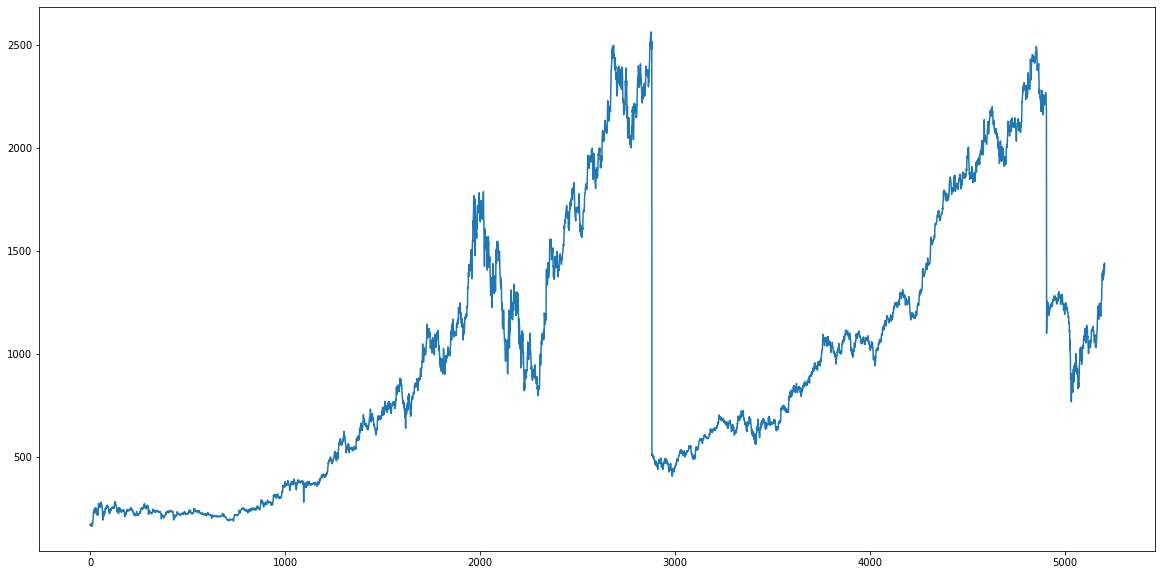

In [ ]:
# Plotting the data series
plt.figure(figsize=(20,10))
plt.plot(stock)

In [ ]:
# Scaling the data
def minmax(X):
  return (X - X.min())/ (X.max() - X.min())

stock_scaled = minmax(stock)

In [ ]:
# Spliting the data into train data and test data
train = stock_scaled.head(3642)
test = stock_scaled.tail(1562)

In [ ]:
train.values

array([0.00274725, 0.004329  , 0.00147769, ..., 0.28113553, 0.27913753,
       0.27141608])

In [ ]:
train.shape

(3642,)

In [ ]:
test.values

array([0.27039627, 0.27339327, 0.26914752, ..., 0.51590077, 0.52582834,
       0.53173909])

In [ ]:
test.shape

(1562,)

In [ ]:
# Prepare data
def prepare_data(data, time_step):
    X, y =[],[]
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + time_step
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# Spliting the data further
time_step = 100
X_train, y_train = prepare_data(train.values,time_step)
X_test, y_test = prepare_data(test.values, time_step)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# Preparing model
model=Sequential()
model.add(GRU(50,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(50,return_sequences=True))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# Fitting model
model.fit(X_train,y_train,epochs=100,batch_size=64)

In [ ]:
# Testing model
y_pred = model.predict(X_test)

In [ ]:
# reverse scaling
def minmax_reverse(X_norm,X):
    return (X_norm * (X.max() - X.min())) + X.min()

In [ ]:
y_pred_actual = minmax_reverse(y_pred,stock)
y_test_actual = minmax_reverse(y_test,stock)

In [ ]:
# Finding Root mean squared error
np.sqrt(mean_squared_error(y_test_actual,y_pred_actual))

34.07014224539382

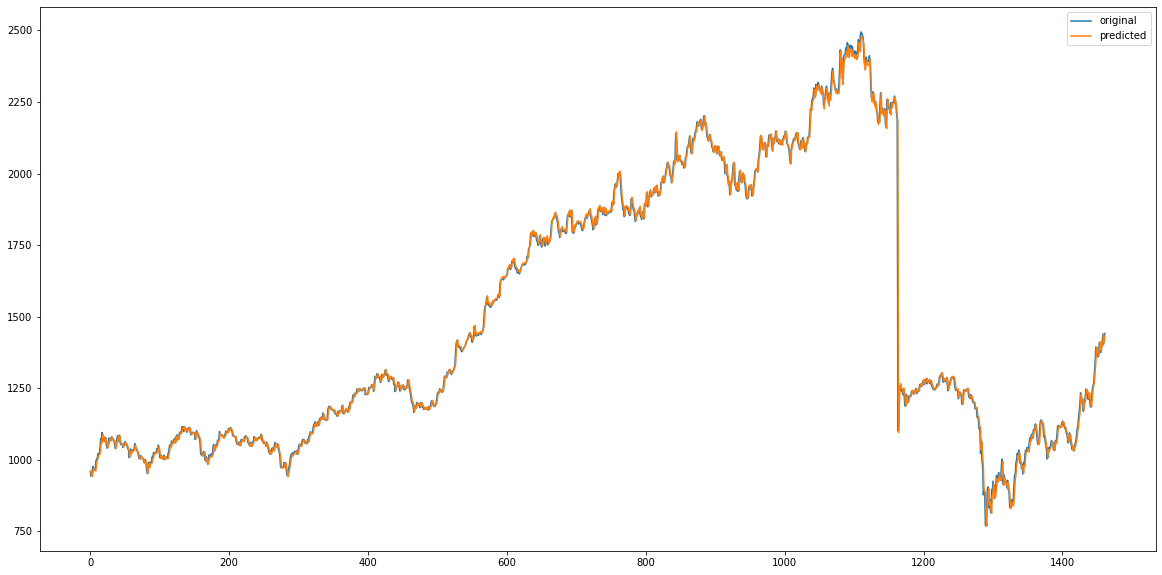

In [ ]:
# plot original and predicted values
plt.figure(figsize=(20,10))
plt.plot(y_test_actual,label="original")
plt.plot(y_pred_actual,label="predicted")
plt.legend()
plt.show()

In [ ]:
# Making prediction for next 200 days
n = 200
predicted_values = []
last_100 = X_test[-1].reshape(1,100,1)

while n>=1:
  predicted = model.predict(last_100)
  predicted_values.append(predicted[0][0])
  last_100 = np.append(last_100,predicted)[1:].reshape(1,100,1)
  n-=1

In [ ]:
forecast = minmax_reverse(np.array(predicted_values),stock)

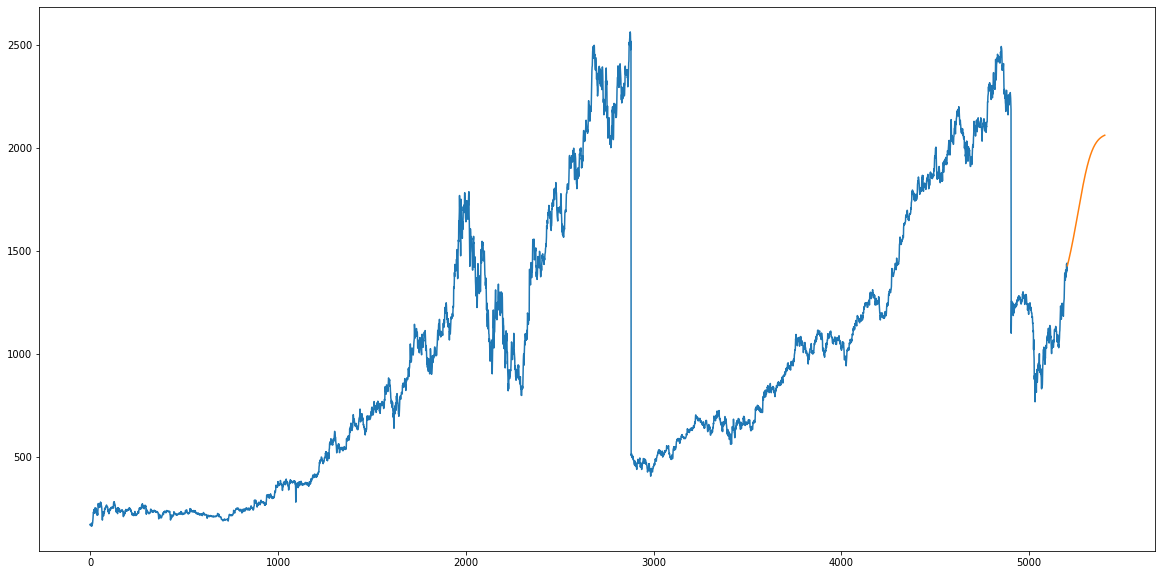

In [ ]:
# Ploting the predictions for next 200 days
plt.figure(figsize=(20,10))
plt.plot(stock.index,stock)
plt.plot(np.arange(5204,5404),forecast)
plt.show()